In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product

from copy import deepcopy
from tqdm.notebook import tqdm
import ordpy

In [2]:
def runge_kutta(time_steps, y0, system, params):
    ys = [y0]
    for t in range(len(time_steps)-1):
        dt = time_steps[t+1]-time_steps[t]
        t0 = time_steps[t]
        t1 = time_steps[t+1]
        k1 = system(t0, y0, params)
        k2 = system(t0 + dt/2, y0 + dt / 2 * k1, params)
        k3 = system(t0 + dt/2, y0 + dt / 2 * k2, params)
        k4 = system(t1, y0 + dt * k3, params)
        y0  = y0 + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        ys.append(y0)
    return np.array(ys)

def lorentz_ode(t, xyz, params):
    x, y, z = xyz
    σ = params['σ']
    ρ = params['ρ']
    β = params['β']
    
    dx = σ * (y - x)
    dy = x * (ρ - z) - y
    dz = x * y - β * z
    
    return np.array([dx, dy, dz])

def get_data(p1 = 10., p2 = 28., p3 = 8/3):
    time_steps = np.arange(0, 1500, 0.1)
    params = {'σ' : p1, 'ρ' : p2, 'β' : p3}
    xyz0 = np.array([1., 1., 1.])
    lorenz_solution = runge_kutta(time_steps, xyz0, lorentz_ode, params)
    x, y, z = lorenz_solution[2000:].T

    x = (x - min(x)) / (max(x) - min(x))
    return x

In [3]:
# Hyper params
L = 4
K = 10
eps = 0.05
beta = 1

In [4]:
# Builds matrix of patterns
z_vectors = np.array(list(product(np.arange(1, K + 1), repeat=L)))
patterns = np.cumsum(z_vectors, axis=1)
patterns = np.hstack([np.zeros((z_vectors.shape[0], 1)), patterns]).astype(int)

train_patterns_size = int(patterns.shape[0])

In [5]:
def fit(train_data, train_points_number, start_index, iteration):
    global patterns

    z_vectors_list = []
    for i in tqdm(range(patterns.shape[0]), desc=f"Computing matrix of Z-vectors, iteration " + str(iteration) + "/10", leave=False):
        pattern = patterns[i]
        vecs = []
        for j in range(train_points_number - pattern[-1] - start_index):
            vecs.append(train_data[pattern + j + start_index])
        z_vectors_list.append(np.array(vecs))
    return z_vectors_list

In [6]:
def norm(a):
    return np.sqrt(np.sum(np.square(a), axis=1))

In [7]:
def predict_with_demon(train_data, train_points_number, X, predicted_points_number, start, max_mape=0.05):
  global patterns, eps

  x_with_predictions = deepcopy(train_data)
  predictions = []
  for T in tqdm(range(start + train_points_number, start + train_points_number + predicted_points_number), desc="Demon predictions", leave=False):
      St = []
      for i in tqdm(range(patterns.shape[0]), desc="Inner loop", leave=False):
          normalized_predicted = norm(X[i][:, :-1] - x_with_predictions[(patterns[i] + T - patterns[i][-1])[:-1]])
          St.extend(X[i][(normalized_predicted < eps), :][:, -1])
      if len(St) == 0:
         predicted_value = np.inf
      else:
         predicted_value = np.mean(St)
         if abs(predicted_value - train_data[T]) / train_data[T] > max_mape:
            predicted_value = np.inf
      predictions.append(predicted_value)
      x_with_predictions[T] = predicted_value
  return predictions

In [8]:
x = get_data()
points_number = x.shape[0]

In [9]:
step = 50
M = 10

predicted_points_number = 50

In [10]:
def calculate(train_points_number):
    actual_vals_matrix = []
    predicted_vals_matrix = []

    for i in tqdm(range(M), "Overall iterations loop"):
        start = step * i
        X = fit(x, train_points_number, start, i + 1)
        # x_motives_list.append(X)

        actual_vals = x[start + train_points_number : start + train_points_number + predicted_points_number]
        predicted_vals = predict_with_demon(x, train_points_number, X, predicted_points_number, start)

        actual_vals_matrix.append(np.array(actual_vals))
        predicted_vals_matrix.append(np.array(predicted_vals))

    actual_vals_matrix = np.array(actual_vals_matrix)
    predicted_vals_matrix = np.array(predicted_vals_matrix)

    unpredicted_points = np.zeros((predicted_points_number))
    loss = np.zeros((predicted_points_number))

    for i in range(M):
        for j in range(predicted_points_number):
            if predicted_vals_matrix[i][j] == np.inf:
                unpredicted_points[j] += 1
            else:
                loss[j] += abs(predicted_vals_matrix[i][j] - actual_vals_matrix[i][j]) * 100 / actual_vals_matrix[i][j]
    loss /= M
    unpredicted_points /= M

    return loss, unpredicted_points

In [11]:
def plots(train_points_number, loss, unpredicted_points):
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(f"Trained on original series, train_size={train_points_number}")

    plt.subplot(1, 2, 1)
    plt.title("MAPE, %")
    plt.plot(loss)

    plt.subplot(1, 2, 2)
    plt.ylim((-0.1, 1.1))
    plt.title("Unpredicted points")
    plt.plot(unpredicted_points)

    plt.show()

In [ ]:
data1 = calculate(1000)

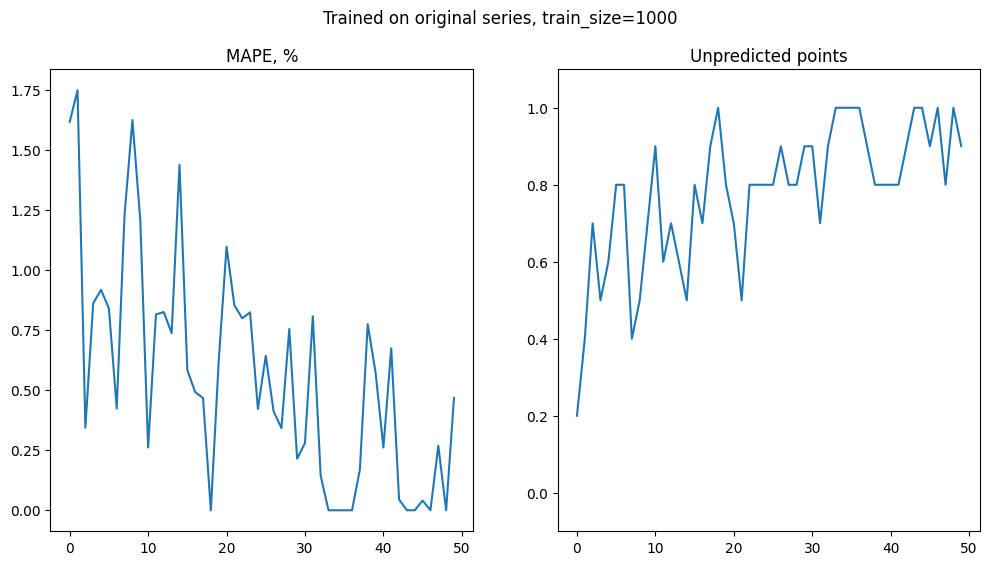

In [13]:
plots(1000, *data1)

In [ ]:
data2 = calculate(2500)

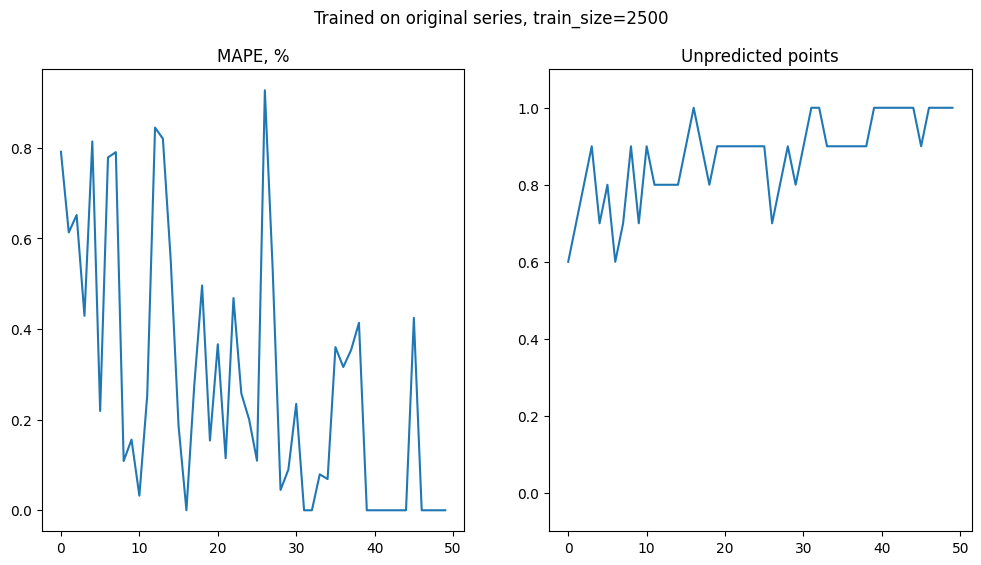

In [15]:
plots(2500, *data2)

In [ ]:
data3 = calculate(5000)

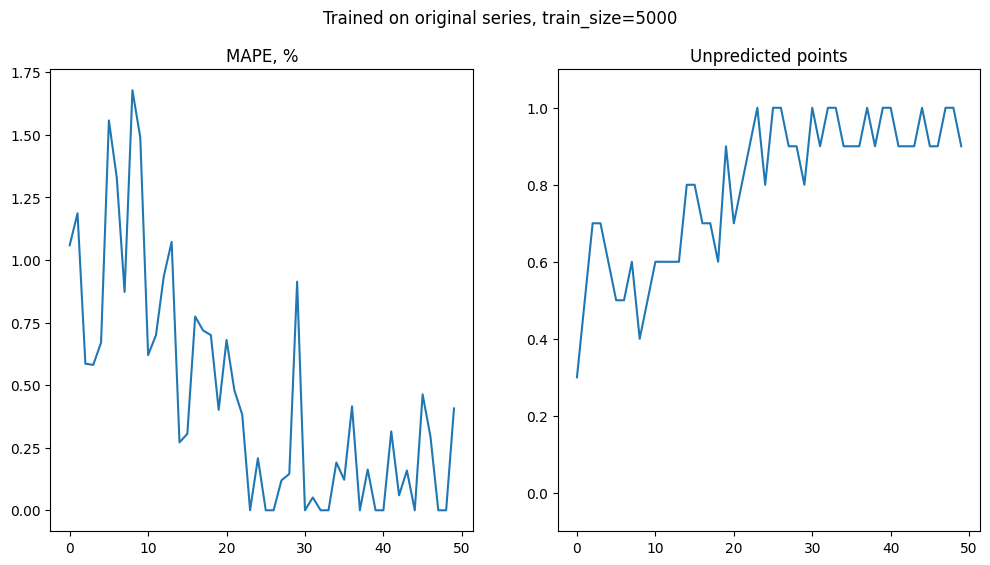

In [17]:
plots(5000, *data3)

In [ ]:
data4 = calculate(10000)

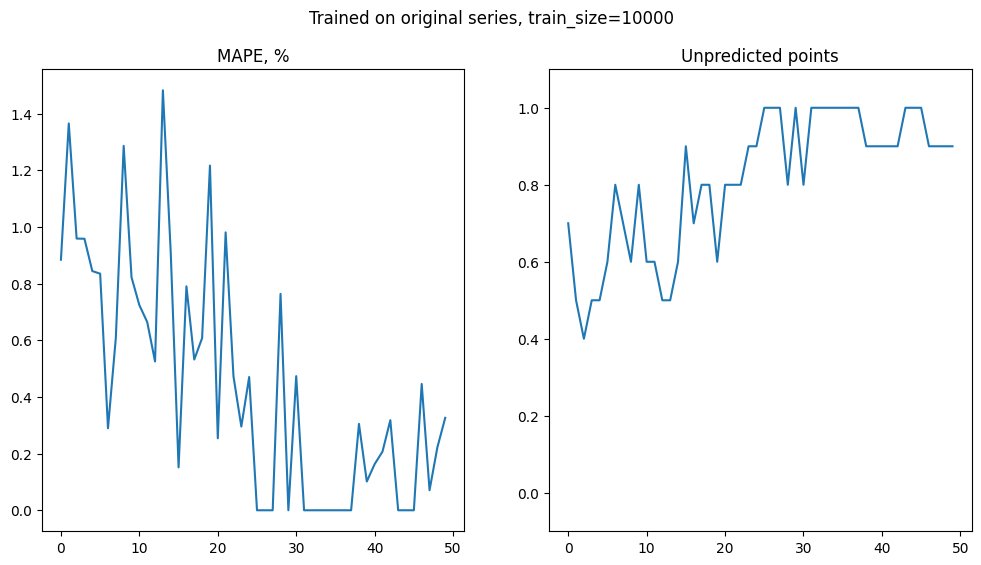

In [19]:
plots(10000, *data4)